# DDIM Inversion

In this notebook we will explore **inversion**, see how it relates to sampling, and apply it to the task of editing images with Stable Diffusion.

## What You Will Learn

- How DDIM sampling works
- Deterministic vs Stochastic samplers
- The theory behind DDIM inversion
- Editing images with inversion



Let's get started!

## Setup

In [2]:
!pip install -q transformers diffusers accelerate matplotlib

In [1]:
import torch
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler

# Useful function for later
def load_image(url, size=None):
    response = requests.get(url,timeout=0.2)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Loading an existing pipeline

In [3]:
# Load a pipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [4]:
# Set up a DDIM scheduler:
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

  0%|          | 0/50 [00:00<?, ?it/s]

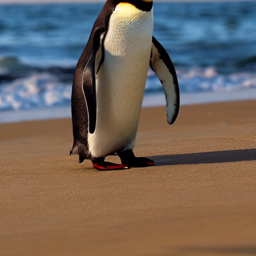

In [5]:
# Sample an image to make sure it is all working
prompt = 'Beautiful DSLR Photograph of a penguin on the beach, golden hour'
negative_prompt = 'blurry, ugly, stock photo'
im = pipe(prompt, negative_prompt=negative_prompt).images[0]
im.resize((256, 256)) # resize for convenient viewing

## DDIM Sampling

At a given time $t$, the noisy image $x_t$ is some mixture of the original image ($x_0$) and some noise ($\epsilon$). Here is the formula for $x_t$ from the DDIM paper, which we'll be referring to in this section:

$$ x_t = \sqrt{\alpha_t}x_0 + \sqrt{1-\alpha_t}\epsilon $$

$\epsilon$ is some gaussian noise with unit variance
$\alpha_t$ ('alpha') is the value which is confusingly called $\bar{\alpha}$ ('alpha_bar') in the DDPM paper (!!) and defined the noise scheduler. In diffusers, the alpha scheduler is calculated and the values are stored in the `scheduler.alphas_cumprod`. Confusing I know! Let's plot these values, and remember that for the rest of this notebook we'll use DDIM's notation.

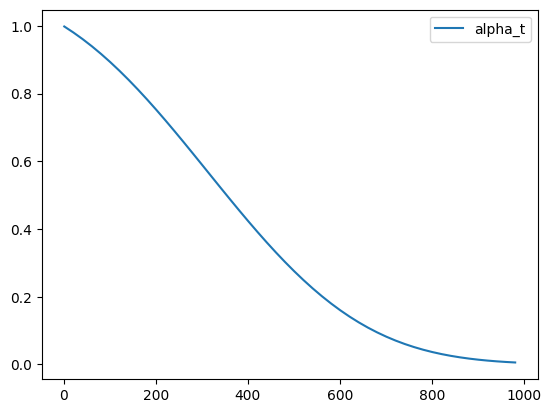

In [8]:
# Plot 'alpha' (alpha_bar in DDPM language, alphas_cumprod in diffusers for clarity)
timesteps = pipe.scheduler.timesteps.cpu()
alphas = pipe.scheduler.alphas_cumprod[timesteps]
plt.plot(timesteps, alphas, label='alpha_t');
plt.legend();

Initially (timestep 0, left side of the graph) we begin with a clean image and no noise. $\alpha_t = 1$. As we move to higher timesteps, we end up with almost all noise and $\alpha_t$ drops towards 0.

During sampling, we begin with pure noise at timestep 1000 and slowly move towards timestep 0. To calculate the next t in the sampling trajectory ($x_{t-1}$ since we're moving from high t to low t) we predict the noise ($\epsilon_\theta(x_t)$, which is the output of our model) and use this to calculate the predicted denoised image $x_0$. Then we use this prediction to move a small distance in the 'direction pointing to $x_t$'. Finally, we can add some additional noise scaled by $\sigma_t$. Here's the relevant section from the paper showing this in action:

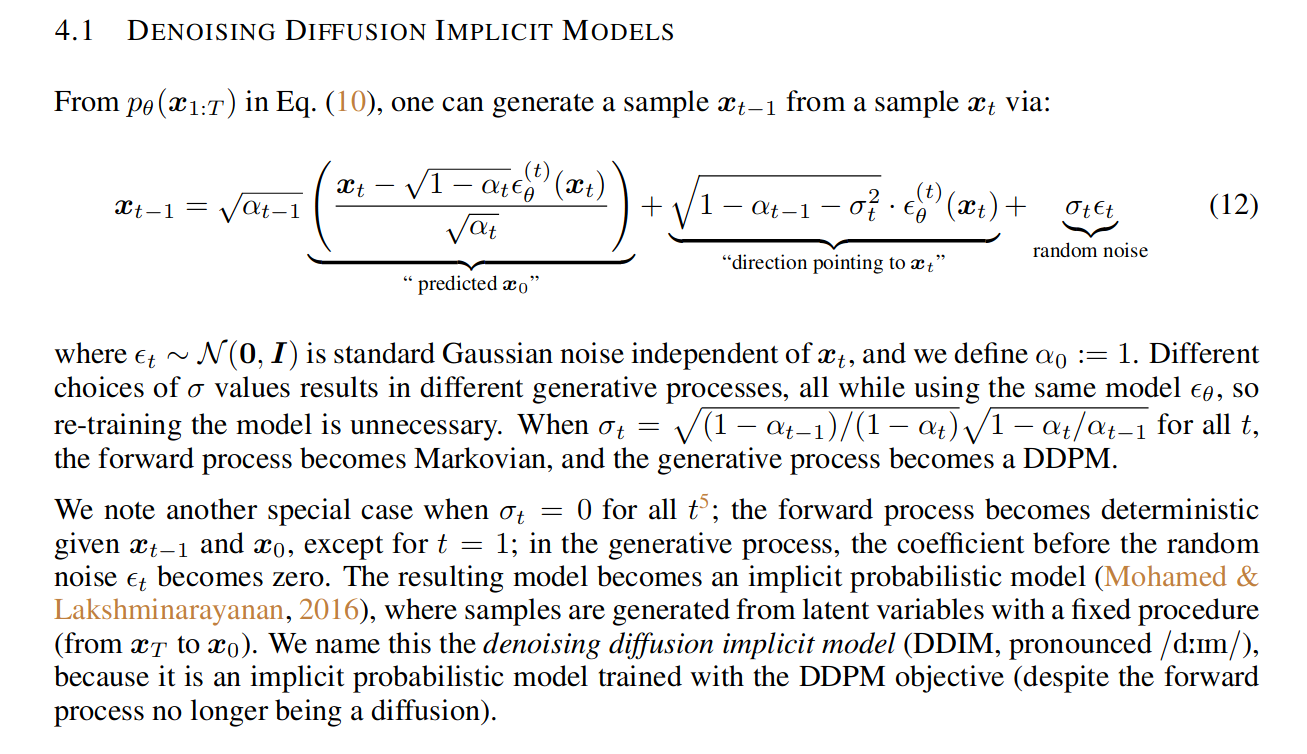

So, we have an equation for how to move from $x_t$ to $x_{t-1}$, with a controllable abount of noise. And today we're specifically interested in the case where we don't add any additional noise - giving us fully deterministic DDIM sampling. Let's see what this looks like in code:

In [6]:
# Sample function (regular DDIM)
@torch.no_grad()
def sample(
    prompt,
    start_step=0,
    start_latents=None,
    guidance_scale=3.5,
    num_inference_steps=30,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt='',
    device=device
):
  
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt
    )

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):
    
        t = pipe.scheduler.timesteps[i]

        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)


        # Normally we'd rely on the scheduler to handle the update step:
        # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

        # Instead, let's do it ourselves:
        prev_t = max(1, t.item() - (1000//num_inference_steps)) # t-1
        alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
        alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
        predicted_x0 = (latents - (1 - alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
        direction_pointing_to_xt = (1 - alpha_t_prev).sqrt() * noise_pred
        latents = alpha_t_prev.sqrt() * predicted_x0 + direction_pointing_to_xt

    # Post-processing
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

  0%|          | 0/50 [00:00<?, ?it/s]

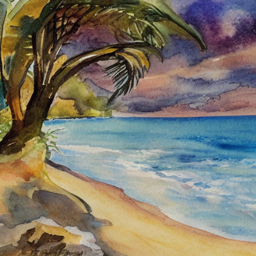

In [7]:
# Test our sampling function by generating an image
sample(
    'Watercolor painting of a beach sunset',
    negative_prompt=negative_prompt,
    num_inference_steps=50
)[0].resize((256, 256))

See if you can match the code with the equation from the paper. Note that $\sigma$=0 since we're only interested in the no-extra-noise case, so we can leave out those bits of the equation.

## Inversion

The goal of inversion is to 'reverse' the sampling process. We want to end up with a noisy latent which, if used as the starting point for our usual sampling procedure, results in the original image being generated. 

Here we load an image as our initial image, but you can also generate one yourself to use instead.

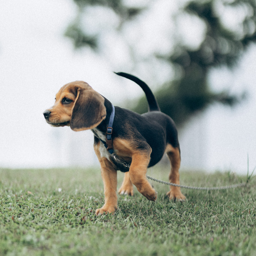

In [8]:
# https://www.pexels.com/photo/a-beagle-on-green-grass-field-8306128/
input_image = load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
input_image.resize((256, 256))

We're also going to use a prompt to do the inversion with classifier-free-guidance included, so enter a description of the image:

In [9]:
input_image_prompt = "Photograph of a puppy on the grass"

Next, we need to turn this PIL image into a set of latents which we will use as the starting point for our inversion:

In [10]:
# encode with VAE
with torch.no_grad():
    latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
    
l = 0.18215 * latent.latent_dist.sample()

Alright, time for the fun bit. This function looks similar to the sampling function above, but we move through the timesteps in the opposite direction, starting at t=0 and moving towards higher and higher noise. And instead of updating our latents to be less noisy, we estimate the predicted noise and use it to UNDO an update step, moving them from t to t+1. 

In [30]:
## Inversion
@torch.no_grad()
def invert(
    start_latents,
    prompt,
    guidance_scale=3.5,
    num_inference_steps=80,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt='',
    device=device
):
  
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt
    )

    # latents are now the specified start latents
    latents = start_latents.clone()

    # We'll keep a list of the inverted latents as the process goes on
    intermediate_latents = []

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Reversed timesteps <<<<<<<<<<<<<<<<<<<<
    timesteps = reversed(pipe.scheduler.timesteps)

    for i in tqdm(range(1, num_inference_steps), total=num_inference_steps-1):

        # We'll skip the final iteration
        if i >= num_inference_steps - 1:
            continue

        t = timesteps[i]

        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        current_t = max(0, t.item() - (1000//num_inference_steps)) #t
        next_t = t # min(999, t.item() + (1000//num_inference_steps)) # t+1
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]

        # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
        latents = (latents - (1-alpha_t).sqrt()*noise_pred)*(alpha_t_next.sqrt()/alpha_t.sqrt()) + (1-alpha_t_next).sqrt()*noise_pred


        # Store
        intermediate_latents.append(latents)
            
    return torch.cat(intermediate_latents)


Running it on the latent representation of our puppy pic, we get back a set of all the intermediate latents created during the inversion process:

In [32]:
inverted_latents = invert(l, input_image_prompt, num_inference_steps=50)
inverted_latents.shape

  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([48, 4, 64, 64])

We can view the final set of latents - these will hopefully be the noisy starting point for our new sampling attempts:

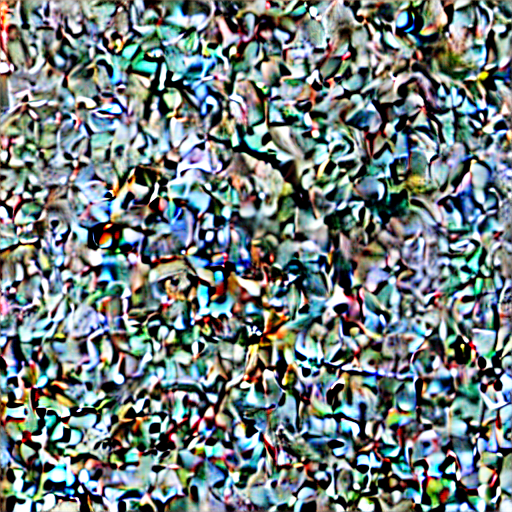

In [16]:
# Decode the final inverted latents:
with torch.no_grad():
    im = pipe.decode_latents(inverted_latents[-1].unsqueeze(0))
pipe.numpy_to_pil(im)[0]

You can pass these inverted latents to the pipeline using the normal __call__ method:


  0%|          | 0/50 [00:00<?, ?it/s]

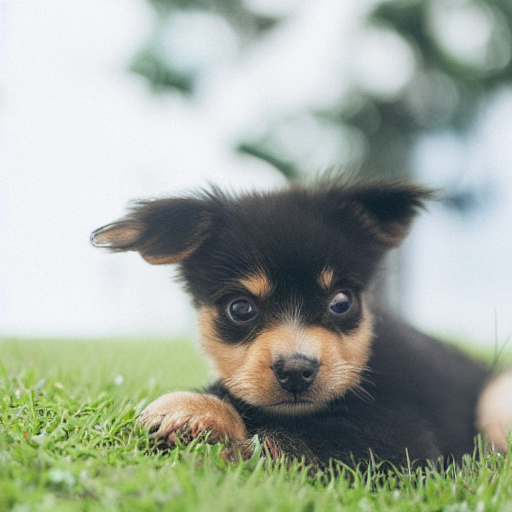

In [17]:
pipe(input_image_prompt, latents=inverted_latents[-1][None], num_inference_steps=50, guidance_scale=3.5).images[0]

But here we see our first problem: this is **not quite the image we started with**! This is because DDIM inversion relies on a critical assumption that the noise prediction at time t and at time t+1 will be the same - something that is not true when we only invert over 50 or 100 timesteps. We could use more timesteps to hopefully get a more accurate inversion, but we can also 'cheat' and start from, say, 20/50 steps through sampling with the corresponding intermediate latents we saved during inversion:

  0%|          | 0/30 [00:00<?, ?it/s]

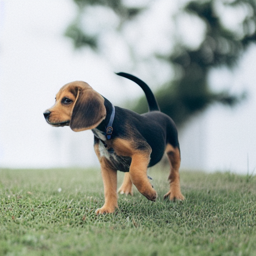

In [22]:
# The reason we want to be able to specify start step
start_step=20
sample(
    input_image_prompt,
    start_latents=inverted_latents[-(start_step+1)][None],
    start_step=start_step, num_inference_steps=50
)[0].resize((256, 256))

  0%|          | 0/30 [00:00<?, ?it/s]

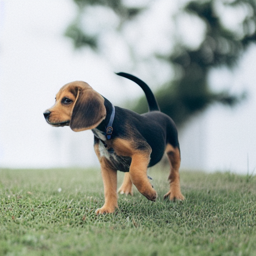

In [23]:
# The reason we want to be able to specify start step
start_step=20
sample(
    input_image_prompt,
    start_latents=inverted_latents[48-(start_step+1)][None],
    start_step=start_step, num_inference_steps=50
)[0].resize((256, 256))

Pretty close to our input image! Why are we doing this? Well, the hope is that if we now sample with a new prompt we'll get an oimage that matches the original EXCEPT in places relevant to the new prompt. For ex, replacing 'puppy' with 'cat' we should see a cat with a near-identical lawn and backgorund:

  0%|          | 0/40 [00:00<?, ?it/s]

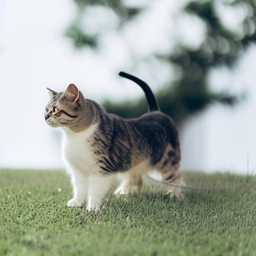

In [33]:
# Sampling with a new prompt
start_step = 10
new_prompt = input_image_prompt.replace('puppy', 'cat')
sample(
    new_prompt,
    start_latents=inverted_latents[-(start_step + 1)][None], 
    start_step=start_step,
    num_inference_steps=50
)[0].resize((256, 256))

Actual starting point: 37


  0%|          | 0/40 [00:00<?, ?it/s]

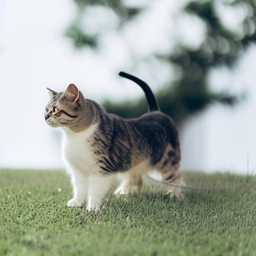

In [34]:
# Sampling with a new prompt
start_step = 10
print(f'Actual starting point: {48-(start_step+1)}')
new_prompt = input_image_prompt.replace('puppy', 'cat')
sample(
    new_prompt,
    # start_latents=inverted_latents[48-(start_step+1)][None], 
    start_latents=inverted_latents[48-(start_step+1)][None], 
    start_step=start_step,
    num_inference_steps=50
)[0].resize((256, 256))

### Why not just use img2img?

Why bother inverting? Can't we just add noise to the input image and denoise with the new prompt? We can, but this will result in much more drastic changes everywhere (if we add lots of noise) or not enough changes anywhere (if we add less noise). Try it yourself:

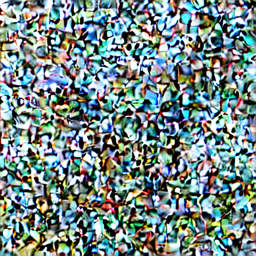

  0%|          | 0/40 [00:00<?, ?it/s]

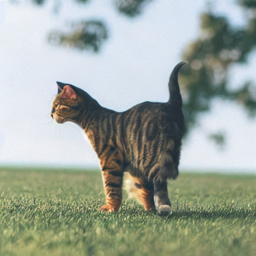

In [52]:
start_step = 10
num_inference_steps=50
generator = torch.Generator(device=device).manual_seed(100)

pipe.scheduler.set_timesteps(num_inference_steps)


noisy_l = pipe.scheduler.add_noise(
    l, 
    torch.randn(*l.shape, device=device, generator=generator),
    pipe.scheduler.timesteps[start_step]
)

with torch.inference_mode():
    decoded_latent = pipe.decode_latents(noisy_l)
img = pipe.numpy_to_pil(decoded_latent)
display(img[0].resize((256, 256)))

sample(
    new_prompt,
    start_latents=noisy_l, # latent of the original with the addition of a certain amount of noise
    start_step=start_step, # point from which to start the sampling process to the denoise the image
    num_inference_steps=num_inference_steps
)[0].resize((256, 256))

In [53]:
pipe.scheduler.timesteps

tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')

Note the much-larger change to the lawn and background.

# Putting it all together

Let's wrap the code we've written so far into a simple function that takes an image and two prompts and performs an edit using inversion:

In [63]:
def edit(
    input_image,
    input_image_prompt,
    edit_prompt,
    num_steps=100,
    start_step=30,
    guidance_scale=3.5
):
    
    # turn clean image into its corresponding latent
    with torch.no_grad():
            latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
    l = 0.18215 * latent.latent_dist.sample()
    
    # compute inverted latent for each inference step
    print('[INFO] Computing inverted latents...')
    inverted_latents = invert(l, input_image_prompt, num_inference_steps=num_steps)
    
    # sampling process using an inverted latent as a starting latent instead of starting from pure noise
    print('[INFO] Computing image using inverted latent...')
    final_im = sample(
        edit_prompt,
        start_latents=inverted_latents[-(start_step+1)][None],
        start_step=start_step,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale
    )[0].resize((256, 256))
    
    return final_im

And in action:

[INFO] Computing inverted latents...


  0%|          | 0/49 [00:00<?, ?it/s]

[INFO] Computing image using inverted latent...


  0%|          | 0/40 [00:00<?, ?it/s]

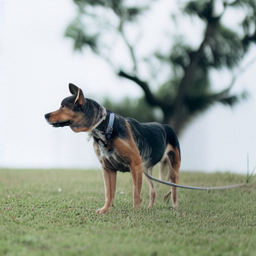

In [64]:
edit(input_image, 'A puppy on the grass', 'an old grey dog on the grass', num_steps=50, start_step=10)

[INFO] Computing inverted latents...


  0%|          | 0/49 [00:00<?, ?it/s]

[INFO] Computing image using inverted latent...


  0%|          | 0/38 [00:00<?, ?it/s]

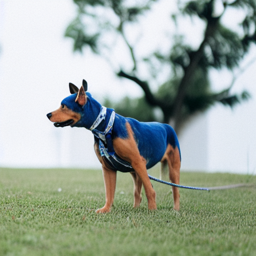

In [65]:
edit(input_image, 'A puppy on the grass', 'A blue dog on the lawn', num_steps=50, start_step=12, guidance_scale=6)

In [ ]:
# Exercise: Try this on some more images! Explore the different parameters

## More Steps = Better Performance

If you've having issues with less-accurate inversions, you can try using more steps (at the cost of longer running time). To test the inversion you can use our edit function with the same prompt:

In [ ]:
# Inversion test with far more steps:
edit(input_image, 'A puppy on the grass', 'A puppy on the grass', num_steps=350, start_step=1)

Much better! And trying it for an edit:

In [ ]:
edit(
    input_image,
    'A photograph of a puppy',
    'A photograph of a grey cat',
    num_steps=150,
    start_step=30,
    guidance_scale=5.5
)

In [ ]:
# source: https://www.pexels.com/photo/girl-taking-photo-1493111/
face = load_image('https://images.pexels.com/photos/1493111/pexels-photo-1493111.jpeg', size=(512, 512))
face

In [ ]:
edit(
    face,
    'A photograph of a face',
    'A photograph of a face with sunglasses',
    num_steps=250,
    start_step=30,
    guidance_scale=3.5
)

In [ ]:
edit(
    face,
    'A photograph of a face',
    'Acrylic palette knife painting of a face, colorful',
    num_steps=250,
    start_step=65,
    guidance_scale=5.5
)

# What Next?

Armed with the knowledge from this notebook, I recommend you investigate ['Null-text Inversion'](https://null-text-inversion.github.io/) which builds on DDIM by optimizing the null text (unconditional text prompt) during inversion for more accurate inversions and better edits. 